# Devlog 2023-07-13

Now that we have done a compatibility pass with all of the system modules, let's do a compatibility test. The results of this test should comport with [the analysis in this spreadsheet](https://docs.google.com/spreadsheets/d/1FF_ovXYQUb65JagcLj8QCmCzs2_Pzd9qnZ5Cr28v4jw/edit?usp=sharing).

Generate the cross product of all available modules and test them one-by-one to see if they run successfully. We'll just run each simulation for a few days and verify that this doesn't throw any exceptions. Ideally, these results will line up with our expected compatibility matrix.

_Note: also requires the `seaborn` library._

In [1]:
import multiprocessing
import time
from datetime import date
from functools import cache
from itertools import product
from typing import NamedTuple

import numpy as np
import pandas as pd

from epymorph import *
from epymorph.geo.dynamic import DynamicGeo
from epymorph.geo.static import StaticGeo
from epymorph.geo.util import convert_to_static_geo

geo_order = ['pei', 'single_pop', 'us_counties_2015',
             'us_states_2015', 'us_sw_counties_2015', 'maricopa_cbg_2019']
mm_order = ['pei', 'sparsemod', 'centroids', 'icecube', 'no']
ipm_order = ['pei', 'sirs', 'sirh', 'sparsemod', 'no']


@cache
def load_geo(name) -> StaticGeo:
    g = geo_library[name]()
    if isinstance(g, DynamicGeo):
        g = convert_to_static_geo(g)
    if isinstance(g, StaticGeo):
        return g
    raise Exception(f"Couldn't load geo '{name}' for some reason; unexpected type.")


# Params to satisfy every combo!
params = {
    # SIRS
    'beta': 0.4,
    'gamma': 1 / 10,
    'xi': 1 / 90,

    # Pei
    'infection_duration': 4.0,
    'immunity_duration': 90.0,

    # SIRH
    'hospitalization_duration': 14.0,
    'hospitalization_prob': 0.1,

    # Sparsemod
    'omega_1': 0.55,
    'omega_2': 0.05,
    'delta_1': 0.333,
    'delta_2': 0.5,
    'delta_3': 0.166,
    'delta_4': 0.142,
    'delta_5': 0.125,
    'gamma_a': 0.166,
    'gamma_b': 0.333,
    'gamma_c': 0.25,
    'rho_1': 0.40,
    'rho_2': 0.175,
    'rho_3': 0.015,
    'rho_4': 0.20,
    'rho_5': 0.60,

    # Centroids MM
    'phi': 40,

    # Pei MM
    'theta': 0.1,
    'move_control': 0.9,
}


class Result(NamedTuple):
    geo: str
    mm: str
    ipm: str
    runs: bool
    runtime: float
    error: str | None


def test(geo: str, mm: str, ipm: str, lock) -> Result:
    t0 = time.perf_counter()

    try:
        geo_loaded = load_geo(geo)

        if ipm == 'no':
            initializer = init.NoInfection()
        else:
            initializer = init.SingleLocation(location=0, seed_size=100)

        rume = Rume.single_strata(
            ipm=ipm_library[ipm](),
            mm=mm_library[mm](),
            scope=geo_loaded.spec.scope,
            params=params | geo_loaded.values,
            time_frame=TimeFrame.of("2010-01-01", duration_days=3),
            init=initializer,
        )
        sim = BasicSimulator(rume)
        sim.run()

        success = True
        error = None
    except Exception as e:
        success = False
        error = repr(e)

    t1 = time.perf_counter()

    with lock:
        msg = f"{'succeeded' if success else 'failed'}: {geo, mm, ipm} in {((t1 - t0) * 1000.0):.3f} ms"
        print(msg)

    return Result(geo, mm, ipm, success, t1 - t0, error)


with multiprocessing.Manager() as manager:
    lock = manager.Lock()

    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        combos = ((*args, lock) for args in product(geo_order, mm_order, ipm_order))
        results = pool.starmap(test, combos)

compat = pd.DataFrame(results)

failed: ('single_pop', 'centroids', 'pei') in 90.128 ms
failed: ('single_pop', 'sparsemod', 'pei') in 91.624 ms
succeeded: ('pei', 'no', 'pei') in 95.319 ms
succeeded: ('pei', 'icecube', 'pei') in 104.071 ms
failed: ('single_pop', 'pei', 'pei') in 105.966 ms
succeeded: ('single_pop', 'centroids', 'sirs') in 30.628 ms
succeeded: ('pei', 'sparsemod', 'pei') in 115.188 ms
succeeded: ('pei', 'no', 'sirs') in 12.014 ms
succeeded: ('pei', 'pei', 'pei') in 122.721 ms
succeeded: ('pei', 'centroids', 'pei') in 110.173 ms
succeeded: ('single_pop', 'sparsemod', 'sirs') in 30.124 ms
succeeded: ('pei', 'icecube', 'sirs') in 20.113 ms
succeeded: ('pei', 'sparsemod', 'sirs') in 28.557 ms
succeeded: ('single_pop', 'pei', 'sirs') in 38.468 ms
succeeded: ('pei', 'centroids', 'sirs') in 27.103 ms
succeeded: ('pei', 'pei', 'sirs') in 43.795 ms
succeeded: ('single_pop', 'centroids', 'sirh') in 155.287 ms
succeeded: ('pei', 'no', 'sirh') in 143.413 ms
succeeded: ('pei', 'icecube', 'sirh') in 159.838 ms
succ

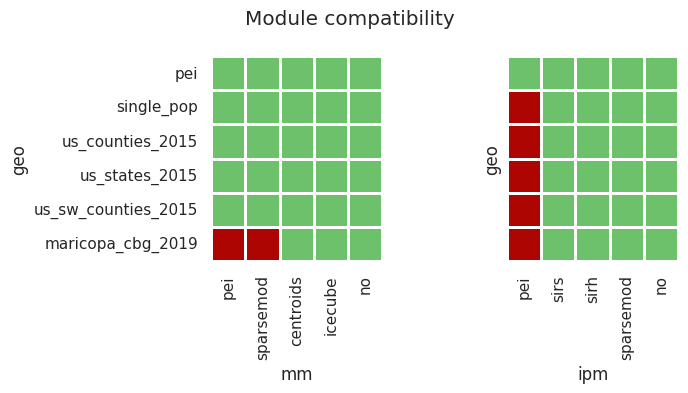

In [2]:
from functools import partial, reduce

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

boolean_or = partial(reduce, bool.__or__)


mm_compat = compat.groupby(by=['geo', 'mm'])\
    .agg({'runs': boolean_or})\
    .reset_index()\
    .pivot(index='geo', columns='mm', values='runs')\
    .reset_index()\
    .reindex(columns=['geo', *mm_order])\
    .sort_values(by='geo', key=lambda x: x.map({k: v for v, k in enumerate(geo_order)}))\
    .set_index('geo')

# display(mm_compat)


ipm_compat = compat.groupby(by=['geo', 'ipm'])\
    .agg({'runs': boolean_or})\
    .reset_index()\
    .pivot(index='geo', columns='ipm', values='runs')\
    .reset_index()\
    .reindex(columns=['geo', *ipm_order])\
    .sort_values(by='geo', key=lambda x: x.map({k: v for v, k in enumerate(geo_order)}))\
    .set_index('geo')

# display(ipm_compat)

palette = ['#AD0501', '#6EC16B']

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

sns.heatmap(mm_compat,
            cmap=palette,
            cbar=False,
            square=True,
            linewidths=1,
            ax=ax1)

sns.heatmap(ipm_compat,
            cmap=palette,
            cbar=False,
            square=True,
            linewidths=1,
            ax=ax2)

plt.suptitle("Module compatibility")
plt.tight_layout()
plt.show()

# NOTE: and when I ran this, it matched my expectations as laid out in this spreadsheet:
# https://docs.google.com/spreadsheets/d/1FF_ovXYQUb65JagcLj8QCmCzs2_Pzd9qnZ5Cr28v4jw/edit?usp=sharing

In [3]:
# What are the slowest sims (that succeed)?
compat\
    .loc[compat['runs'] == True]\
    .sort_values(by='runtime', ascending=False)\
    .reset_index(drop=True)

,geo,mm,ipm,runs,runtime,error
0,us_counties_2015,sparsemod,sparsemod,True,30.364625,None
1,us_counties_2015,pei,sparsemod,True,27.776683,None
2,us_counties_2015,sparsemod,sirh,True,26.853101,None
3,us_counties_2015,centroids,sparsemod,True,26.676122,None
4,us_counties_2015,sparsemod,sirs,True,26.194347,None
...,...,...,...,...,...,...
112,pei,no,sirs,True,0.012014,None
113,single_pop,no,sirs,True,0.010216,None
114,single_pop,icecube,no,True,0.009987,None
115,single_pop,no,no,True,0.004732,None
